# AutoML with Feature Engineering: A Lending Club Analysis

In this tutorial, we will go through a step-by-step workflow to build models using H2O's AutoML to determine loan deliquency. The data for this exercise come from the public Lending Club data set, a description can be found [here](https://www.kaggle.com/pragyanbo/a-hitchhiker-s-guide-to-lending-club-loan-data/notebook).

We will highlight feature engineering methods to improve model performance.

## Workflow

1. Start the H2O-3 cluster
2. Import data
3. Train default models using H2O's AutoML
4. Feature engineering to improve model performance
5. Train models using transformed data with AutoML
6. (Optional) Assignment: Transform test data
7. Stop H2O-3 cluster

# Step 1 (of 7). Start the H2O-3 cluster

The `os` commands below check whether this notebook is being run on the Aquarium platform. We use `h2o.init` command to connect to the H2O-3 cluster, starting it if it is not already up. The parameters used in `h2o.init` will depend on your specific environment.

In [1]:
import os
import h2o

startup = '/home/h2o/bin/aquarium_startup'
if os.path.exists(startup):
    os.system(startup)
    local_url = 'http://localhost:54321/h2o'
    aquarium = True
    !sleep 5
else:
    local_url = 'http://localhost:54321'
    aquarium = False

h2o.init(url=local_url, max_mem_size = "6g")

Checking whether there is an H2O instance running at http://localhost:54321/h2o . connected.


H2O cluster uptime:,05 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.2
H2O cluster version age:,1 month and 6 days
H2O cluster name:,h2o
H2O cluster total nodes:,1
H2O cluster free memory:,13.98 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


Note: The method you use for starting and stopping an H2O-3 cluster will depend on how H2O is installed and configured on your system. Regardless of how H2O is installed, if you start a cluster, you will need to ensure that it is shut down when you are done.

# Step 2 (of 7). Import Data

This exploration of H2O will use a version of the Lending Club Loan Data that can be found on [Kaggle](https://www.kaggle.com/wendykan/lending-club-loan-data). This data consists of 15 variables:

|  Id   | Column Name | Description |
| --- | ----------- | ----------- |
|   1 | loan_amnt   | Requested loan amount (US dollars) |
|   2 | term        | Loan term length (months) |
|   3 | int_rate    | Recommended interest rate |
|   4 | emp_length  | Employment length (years) |
|   5 | home_ownership| Housing status |
|   6 | annual_inc  | Annual income (US dollars) |
|   7 | purpose     | Purpose for the loan |
|   8 | addr_state  | State of residence |
|   9 | dti         | Debt to income ratio |
|  10 | delinq_2yrs | Number of delinquencies in the past 2 years |
|  11 | revol_util  | Percent of revolving credit line utilized |
|  12 | total_acc   | Number of active accounts |
|  13 | bad_loan    | Bad loan indicator |
|  14 | longest_credit_length | Age of oldest active account |
|  15 | verification_status | Income verification status |

In [2]:
if aquarium:
    input_csv = "/home/h2o/data/automl/loan.csv"
else:
    input_csv = "https://s3-us-west-2.amazonaws.com/h2o-tutorials/data/topics/data/automl/loan.csv"

loans = h2o.import_file(input_csv)
loans["bad_loan"] = loans["bad_loan"].asfactor()

loans.describe()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Rows:163987
Cols:15




,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,revol_util,total_acc,bad_loan,longest_credit_length,verification_status
type,int,enum,real,int,enum,real,enum,enum,real,int,real,int,enum,int,enum
mins,500.0,,5.42,0.0,,1896.0,,,0.0,0.0,0.0,1.0,,0.0,
mean,13074.169141456337,,13.715904065566173,5.684352932995329,,71915.670519749,,,15.881530121290105,0.2273570060625282,54.07917280242256,24.579733834274627,,14.854273655448347,
maxs,35000.0,,26.06,10.0,,7141778.0,,,39.99,29.0,150.70000000000002,118.0,,65.0,
sigma,7993.55618873465,,4.3919398705457935,3.610663731100236,,59070.91565491825,,,7.587668224192548,0.6941679229284182,25.285366766770505,11.685190365910659,,6.947732922546696,
zeros,0,,0,14248,,0,,,270,139459,1562,0,,11,
missing,0,0,0,5804,0,4,0,0,0,29,193,29,0,29,0
0,5000.0,36 months,10.65,10.0,RENT,24000.0,credit_card,AZ,27.65,0.0,83.7,9.0,0,26.0,verified
1,2500.0,60 months,15.27,0.0,RENT,30000.0,car,GA,1.0,0.0,9.4,4.0,1,12.0,verified
2,2400.0,36 months,15.96,10.0,RENT,12252.0,small_business,IL,8.72,0.0,98.5,10.0,0,10.0,not verified


# Step 3 (of 7). Train Default Models with AutoML

Start by splitting the data into train and test sets

In [3]:
train, test = loans.split_frame(seed=1234, ratios=[0.75])

and train 6 models excluding the `DeepLearning` algorithm

In [4]:
# Set target and predictor variables
y = "bad_loan"
x = train.col_names
x.remove(y)
x.remove("int_rate")

# Use Auto ML to train models
from h2o.automl import H2OAutoML
aml = H2OAutoML(max_models = 6, exclude_algos = ['DeepLearning'])
aml.train(x = x, y = y, training_frame = train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


Print out a leaderboard with the 6 best models and two ensembles: a stacked ensemble of all models, and a best-of-family stacked ensemble:

In [5]:
print(aml.leaderboard)

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20190902_055132,0.684068,0.445168,0.370223,0.374106,0.139955
StackedEnsemble_BestOfFamily_AutoML_20190902_055132,0.683713,0.445262,0.367608,0.374137,0.139979
XGBoost_3_AutoML_20190902_055132,0.680985,0.444506,0.369439,0.373885,0.13979
GBM_1_AutoML_20190902_055132,0.680339,0.444707,0.3695,0.374063,0.139923
XGBoost_1_AutoML_20190902_055132,0.679465,0.445059,0.369567,0.37426,0.14007
GLM_grid_1_AutoML_20190902_055132_model_1,0.673421,0.44771,0.373882,0.374975,0.140606
XGBoost_2_AutoML_20190902_055132,0.672741,0.447746,0.374719,0.375455,0.140967
DRF_1_AutoML_20190902_055132,0.661455,0.453408,0.383329,0.377379,0.142415


As is frequently the case, the stacked ensemble models are among the best performers.

## Examine the Top Model

The `aml.leader` object contains the top model from the leaderboard

In [6]:
top_model = aml.leader

Details for both training and cross-validated data are contained in `aml.leader`

In [7]:
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20190902_055132

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.1185215385037037
RMSE: 0.34426957243373063
LogLoss: 0.3842024895118254
Null degrees of freedom: 123061
Residual degrees of freedom: 123055
Null deviance: 117105.43670854633
Residual deviance: 94561.45352860852
AIC: 94575.45352860852
AUC: 0.8453474021285182
pr_auc: 0.5705805335729259
Gini: 0.6906948042570364
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20437412367231786: 


,0,1,Error,Rate
0,81689.0,18862.0,0.1876,(18862.0/100551.0)
1,7016.0,15495.0,0.3117,(7016.0/22511.0)
Total,88705.0,34357.0,0.2103,(25878.0/123062.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2043741,0.5449462,244.0
max f2,0.1538292,0.6706094,297.0
max f0point5,0.2946269,0.5495905,175.0
max accuracy,0.3566659,0.8447205,140.0
max precision,0.8873173,1.0,0.0
max recall,0.0855418,1.0,385.0
max specificity,0.8873173,1.0,0.0
max absolute_mcc,0.2043741,0.4315434,244.0
max min_per_class_accuracy,0.1859695,0.7583515,262.0
max mean_per_class_accuracy,0.1760322,0.7611213,273.0


Gains/Lift Table: Avg response rate: 18.29 %, avg score: 18.40 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100031,0.5939683,5.0715094,5.0715094,0.9277011,0.6656094,0.9277011,0.6656094,0.0507308,0.0507308,407.1509367,407.1509367
,2,0.0200062,0.5244809,4.4542241,4.7628667,0.8147847,0.5558425,0.8712429,0.6107259,0.0445560,0.0952867,345.4224076,376.2866722
,3,0.0300011,0.4787145,3.8756143,4.4672761,0.7089431,0.5004338,0.8171723,0.5739818,0.0387366,0.1340234,287.5614343,346.7276140
,4,0.0400042,0.4451154,3.6637436,4.2663522,0.6701868,0.4611742,0.7804184,0.5457742,0.0366487,0.1706721,266.3743632,326.6352208
,5,0.0500073,0.4184624,3.2907079,4.0711916,0.6019496,0.4309672,0.7447189,0.5228090,0.0329172,0.2035894,229.0707917,307.1191642
,6,0.1000065,0.3261999,2.8759741,3.4736314,0.5260848,0.3664122,0.6354107,0.4446170,0.1437964,0.3473857,187.5974065,247.3631412
,7,0.1500057,0.2744224,2.3686583,3.1053270,0.4332846,0.2981554,0.5680390,0.3957991,0.1184310,0.4658167,136.8658281,210.5326988
,8,0.2000049,0.2399546,1.9333085,2.8123343,0.3536486,0.2562665,0.5144436,0.3609174,0.0966639,0.5624806,93.3308485,181.2334266
,9,0.3000033,0.1967086,1.5410494,2.3885841,0.2818950,0.2164463,0.4369295,0.3127616,0.1541024,0.7165830,54.1049433,138.8584133
,10,0.4000016,0.1685215,1.0857091,2.0628720,0.1986023,0.1818308,0.3773489,0.2800296,0.1085691,0.8251521,8.5709085,106.2871988




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.1399550879350799
RMSE: 0.37410571759207306
LogLoss: 0.445168230294053
Null degrees of freedom: 123061
Residual degrees of freedom: 123055
Null deviance: 117106.60132581185
Residual deviance: 109566.5855128935
AIC: 109580.5855128935
AUC: 0.6840682061113842
pr_auc: 0.32370820556663804
Gini: 0.3681364122227684
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1891273786869703: 


,0,1,Error,Rate
0,72423.0,28128.0,0.2797,(28128.0/100551.0)
1,10371.0,12140.0,0.4607,(10371.0/22511.0)
Total,82794.0,40268.0,0.3128,(38499.0/123062.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1891274,0.3867535,256.0
max f2,0.1167089,0.5536572,343.0
max f0point5,0.2638213,0.3515165,194.0
max accuracy,0.6214459,0.8176448,32.0
max precision,0.8608241,1.0,0.0
max recall,0.0728885,1.0,398.0
max specificity,0.8608241,1.0,0.0
max absolute_mcc,0.1906108,0.2143248,254.0
max min_per_class_accuracy,0.1668808,0.6310693,280.0
max mean_per_class_accuracy,0.1610941,0.6333832,287.0


Gains/Lift Table: Avg response rate: 18.29 %, avg score: 18.29 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100031,0.5614372,2.8110906,2.8110906,0.5142161,0.6282756,0.5142161,0.6282756,0.0281196,0.0281196,181.1090569,181.1090569
,2,0.0200062,0.4997683,2.4247321,2.6179114,0.4435418,0.5272121,0.4788790,0.5777439,0.0242548,0.0523744,142.4732149,161.7911359
,3,0.0300011,0.4593959,2.4444815,2.5601327,0.4471545,0.4781324,0.4683099,0.5445580,0.0244325,0.0768069,144.4481524,156.0132730
,4,0.0400042,0.4282641,2.1760417,2.4640905,0.3980504,0.4430352,0.4507414,0.5191722,0.0217671,0.0985740,117.6041672,146.4090461
,5,0.0500073,0.4031684,2.1671599,2.4046947,0.3964257,0.4151309,0.4398765,0.4983605,0.0216783,0.1202523,116.7159870,140.4694693
,6,0.1000065,0.3181939,1.9253123,2.1650230,0.3521859,0.3553873,0.3960348,0.4268797,0.0962640,0.2165164,92.5312264,116.5022954
,7,0.1500057,0.2696766,1.6836487,2.0045736,0.3079798,0.2924341,0.3666847,0.3820669,0.0841811,0.3006974,68.3648703,100.4573563
,8,0.2000049,0.2381530,1.4766354,1.8725944,0.2701121,0.2530911,0.3425426,0.3498243,0.0738306,0.3745280,47.6635433,87.2594393
,9,0.3000033,0.1973348,1.3264842,1.6905626,0.2426459,0.2160763,0.3092446,0.3052428,0.1326463,0.5071743,32.6484176,69.0562585
,10,0.4000016,0.1698215,1.0799340,1.5379085,0.1975459,0.1826765,0.2813205,0.2746019,0.1079916,0.6151659,7.9934036,53.7908549


To get details for the holdout test data, use `model_performance` as shown below

In [8]:
perf = aml.leader.model_performance(test_data=test)
perf


ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.13978747575166794
RMSE: 0.3738816333435864
LogLoss: 0.4447177633346446
Null degrees of freedom: 40924
Residual degrees of freedom: 40918
Null deviance: 39000.48288708934
Residual deviance: 36400.14892894066
AIC: 36414.14892894066
AUC: 0.6862340665768004
pr_auc: 0.32928669724382703
Gini: 0.37246813315360083
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17136964035902652: 


,0,1,Error,Rate
0,21836.0,11584.0,0.3466,(11584.0/33420.0)
1,2909.0,4596.0,0.3876,(2909.0/7505.0)
Total,24745.0,16180.0,0.3541,(14493.0/40925.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1713696,0.3880937,274.0
max f2,0.1204691,0.5576672,339.0
max f0point5,0.2554682,0.3556720,197.0
max accuracy,0.5280643,0.8177642,58.0
max precision,0.8937815,1.0,0.0
max recall,0.0701115,1.0,399.0
max specificity,0.8937815,1.0,0.0
max absolute_mcc,0.1989690,0.2171106,245.0
max min_per_class_accuracy,0.1668677,0.6325117,279.0
max mean_per_class_accuracy,0.1565791,0.6331127,291.0


Gains/Lift Table: Avg response rate: 18.34 %, avg score: 18.29 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100183,0.5586830,2.8861166,2.8861166,0.5292683,0.6249733,0.5292683,0.6249733,0.0289141,0.0289141,188.6116573,188.6116573
,2,0.0200122,0.5000901,2.7731797,2.8297171,0.5085575,0.5276975,0.5189255,0.5763948,0.0277149,0.0566289,177.3179738,182.9717104
,3,0.0300061,0.4573259,2.3065389,2.6554664,0.4229829,0.4784014,0.4869707,0.5437569,0.0230513,0.0796802,130.6538917,165.5466388
,4,0.04,0.4262848,2.1065500,2.5183211,0.3863081,0.4411374,0.4618204,0.5181177,0.0210526,0.1007328,110.6549994,151.8321119
,5,0.0500183,0.4008886,2.1147121,2.4374810,0.3878049,0.4138466,0.4469956,0.4972329,0.0211859,0.1219187,111.4712143,143.7481021
,6,0.1000122,0.3182005,1.9802553,2.2089240,0.3631476,0.3548564,0.4050818,0.4260621,0.0990007,0.2209194,98.0255262,120.8923996
,7,0.1500061,0.2693640,1.6151207,2.0110218,0.2961877,0.2919824,0.3687897,0.3813761,0.0807462,0.3016656,61.5120711,101.1021810
,8,0.2,0.2384347,1.5085121,1.8854097,0.2766373,0.2531893,0.3457544,0.3493333,0.0754164,0.3770819,50.8512084,88.5409727
,9,0.3000122,0.1964041,1.3136303,1.6948011,0.2408991,0.2158333,0.3107998,0.3048297,0.1313791,0.5084610,31.3630314,69.4801066
,10,0.4,0.1698529,1.0820776,1.5416389,0.1984360,0.1822188,0.2827123,0.2741807,0.1081945,0.6166556,8.2077572,54.1638907


We can look at overall performance of the top model by 

In [9]:
print("AUC:     train = {:.4f}, xval = {:.4f}, test = {:.4f}" \
      .format(aml.leader.auc(train = True), aml.leader.auc(xval = True), perf.auc()))
print("Logloss: train = {:.4f}, xval = {:.4f}, test = {:.4f}" \
      .format(aml.leader.logloss(train = True), aml.leader.logloss(xval = True), perf.logloss()))

AUC:     train = 0.8453, xval = 0.6841, test = 0.6862
Logloss: train = 0.3842, xval = 0.4452, test = 0.4447


Note that the cross-validation and test data metrics are very similar, but there is a gap between training and test metrics. Those for training are overly optimistic.

## Examine a Selected Model

In practice, the top performing model ranked by a leaderboard may not necessarily be the model you want to put into production. Other considerations, such as modeling type, regulatory or internal business preferences, likelihood of model approval, etc., may play a role in determining which model to use.  

Here we demonstrate how to select and evaluate any model from the leaderboard.

In [10]:
aml.leaderboard

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20190902_055132,0.684068,0.445168,0.370223,0.374106,0.139955
StackedEnsemble_BestOfFamily_AutoML_20190902_055132,0.683713,0.445262,0.367608,0.374137,0.139979
XGBoost_3_AutoML_20190902_055132,0.680985,0.444506,0.369439,0.373885,0.13979
GBM_1_AutoML_20190902_055132,0.680339,0.444707,0.3695,0.374063,0.139923
XGBoost_1_AutoML_20190902_055132,0.679465,0.445059,0.369567,0.37426,0.14007
GLM_grid_1_AutoML_20190902_055132_model_1,0.673421,0.44771,0.373882,0.374975,0.140606
XGBoost_2_AutoML_20190902_055132,0.672741,0.447746,0.374719,0.375455,0.140967
DRF_1_AutoML_20190902_055132,0.661455,0.453408,0.383329,0.377379,0.142415


We can select an specified model from the leaderboard by indicating its position. The following code will select the best model that is not a stacked ensemble:

In [11]:
m = aml.leaderboard['model_id'].grep("StackedEnsemble", invert=True).min()
select_model = h2o.get_model(aml.leaderboard[int(m),'model_id'])

We can look at performance with the selected model just as we did with the top model

In [12]:
select_model

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190902_055132

Model Summary: 


,number_of_trees
,117.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13727605631166198
RMSE: 0.37050783569536283
LogLoss: 0.4372407524855614
Mean Per-Class Error: 0.35430333148921433
AUC: 0.7013305966696467
pr_auc: 0.354010524480658
Gini: 0.4026611933392934
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19565924812181323: 


,0,1,Error,Rate
0,69405.0,31146.0,0.3098,(31146.0/100551.0)
1,9049.0,13462.0,0.402,(9049.0/22511.0)
Total,78454.0,44608.0,0.3266,(40195.0/123062.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1956592,0.4011383,233.0
max f2,0.1241233,0.5607543,317.0
max f0point5,0.2895202,0.3754948,145.0
max accuracy,0.4477696,0.8197656,53.0
max precision,0.7783270,1.0,0.0
max recall,0.0447105,1.0,396.0
max specificity,0.7783270,1.0,0.0
max absolute_mcc,0.2299459,0.2368245,197.0
max min_per_class_accuracy,0.1844675,0.6447070,245.0
max mean_per_class_accuracy,0.1819680,0.6456967,248.0


Gains/Lift Table: Avg response rate: 18.29 %, avg score: 18.36 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100031,0.4672715,3.3884077,3.3884077,0.6198213,0.5145537,0.6198213,0.5145537,0.0338945,0.0338945,238.8407747,238.8407747
,2,0.0200062,0.4308050,2.7844452,3.0864265,0.5093420,0.4472995,0.5645816,0.4809266,0.0278530,0.0617476,178.4445160,208.6426454
,3,0.0300011,0.4040231,2.4667041,2.8799642,0.4512195,0.4170059,0.5268147,0.4596312,0.0246546,0.0864022,146.6704083,187.9964234
,4,0.0400042,0.3834125,2.3936458,2.7583599,0.4378554,0.3931650,0.5045704,0.4430113,0.0239438,0.1103461,139.3645840,175.8359939
,5,0.0500073,0.3668630,2.2737415,2.6614205,0.4159220,0.3747852,0.4868378,0.4293639,0.0227444,0.1330905,127.3741503,166.1420502
,6,0.1000065,0.3104088,2.0461440,2.3538073,0.3742890,0.3358843,0.4305680,0.3826279,0.1023055,0.2353960,104.6144044,135.3807270
,7,0.1500057,0.2753554,1.6800948,2.1292486,0.3073298,0.2916304,0.3894908,0.3522970,0.0840034,0.3193994,68.0094827,112.9248621
,8,0.2000049,0.2496245,1.5450475,1.9832043,0.2826264,0.2619471,0.3627758,0.3297105,0.0772511,0.3966505,54.5047544,98.3204286
,9,0.3000033,0.2132882,1.3038282,1.7567517,0.2385015,0.2303703,0.3213521,0.2965980,0.1303807,0.5270312,30.3828217,75.6751730
,10,0.4000016,0.1855883,1.1079208,1.5945473,0.2026654,0.1990193,0.2916811,0.2722038,0.1107903,0.6378215,10.7920809,59.4547295




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.13978983045483992
RMSE: 0.3738847823258389
LogLoss: 0.44450641951172787
Mean Per-Class Error: 0.3692611226247592
AUC: 0.6809845367855377
pr_auc: 0.32121551777418733
Gini: 0.36196907357107544
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19227691200716707: 


,0,1,Error,Rate
0,67444.0,33107.0,0.3293,(33107.0/100551.0)
1,9221.0,13290.0,0.4096,(9221.0/22511.0)
Total,76665.0,46397.0,0.344,(42328.0/123062.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1922769,0.3857317,231.0
max f2,0.1189931,0.5527973,318.0
max f0point5,0.2647441,0.3477142,158.0
max accuracy,0.4966693,0.8175716,30.0
max precision,0.6317145,0.6666667,5.0
max recall,0.0385229,1.0,398.0
max specificity,0.7076977,0.9999801,0.0
max absolute_mcc,0.2164312,0.2096068,204.0
max min_per_class_accuracy,0.1819491,0.6288152,242.0
max mean_per_class_accuracy,0.1904259,0.6307389,233.0


Gains/Lift Table: Avg response rate: 18.29 %, avg score: 18.37 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100031,0.4663398,2.8155315,2.8155315,0.5150284,0.5130980,0.5150284,0.5130980,0.0281640,0.0281640,181.5531470,181.5531470
,2,0.0200062,0.4282971,2.4602594,2.6378954,0.4500406,0.4455047,0.4825345,0.4793013,0.0246102,0.0527742,146.0259360,163.7895415
,3,0.0300011,0.4028666,2.3778138,2.5512485,0.4349593,0.4152113,0.4666847,0.4579496,0.0237662,0.0765404,137.7813846,155.1248522
,4,0.0400042,0.3827662,2.1405145,2.4485441,0.3915516,0.3922680,0.4478976,0.4415258,0.0214118,0.0979521,114.0514461,144.8544149
,5,0.0500073,0.3668402,2.1804826,2.3949231,0.3988627,0.3747243,0.4380890,0.4281634,0.0218116,0.1197637,118.0482574,139.4923122
,6,0.1000065,0.3109277,1.9004351,2.1476992,0.3476353,0.3358049,0.3928658,0.3819879,0.0950202,0.2147839,90.0435133,114.7699217
,7,0.1500057,0.2758600,1.6410022,1.9788094,0.3001788,0.2923295,0.3619718,0.3521034,0.0820488,0.2968327,64.1002193,97.8809358
,8,0.2000049,0.2504254,1.4828547,1.8548257,0.2712498,0.2625836,0.3392922,0.3297243,0.0741415,0.3709742,48.2854715,85.4825735
,9,0.3000033,0.2139783,1.3131571,1.6742744,0.2402080,0.2312163,0.3062651,0.2968892,0.1313136,0.5022878,31.3157142,67.4274428
,10,0.4000016,0.1860388,1.1123632,1.5337995,0.2034780,0.1994115,0.2805688,0.2725203,0.1112345,0.6135223,11.2363154,53.3799463



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.6578553,0.0080994,0.6523788,0.678422,0.6437104,0.6562653,0.6584999
auc,0.6810795,0.0027034,0.6761683,0.6865532,0.6781970,0.6802393,0.6842399
err,0.3421447,0.0080994,0.3476212,0.3215780,0.3562896,0.3437348,0.3415001
err_count,8421.0,199.28423,8556.0,7915.0,8769.0,8460.0,8405.0
f0point5,0.3201914,0.0027584,0.3204349,0.3236102,0.3126593,0.3223721,0.3218807
f1,0.3860623,0.0022285,0.3858742,0.3846692,0.3810263,0.3889049,0.3898367
f2,0.4861794,0.0047725,0.4849009,0.474128,0.4876594,0.4900426,0.4941657
lift_top_group,2.842141,0.1898548,3.1661751,3.028533,2.7223852,2.3918004,2.901811
logloss,0.4445064,0.0032908,0.4506643,0.4373258,0.4455015,0.4475052,0.4415354
max_per_class_error,0.4120161,0.0103382,0.4150163,0.4388750,0.4004887,0.4071790,0.3985215


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
,2019-09-02 05:56:00,45.556 sec,0.0,0.5,0.6931472,0.5,0.0,1.0,0.8170759
,2019-09-02 05:56:00,45.861 sec,5.0,0.4546977,0.6059394,0.6693896,0.3138982,2.7085635,0.3555769
,2019-09-02 05:56:01,46.122 sec,10.0,0.4250638,0.5510497,0.6731267,0.3193508,2.8886802,0.3581365
,2019-09-02 05:56:01,46.399 sec,15.0,0.4060522,0.5154541,0.6740908,0.3217987,2.9487585,0.3594692
,2019-09-02 05:56:01,46.669 sec,20.0,0.3940019,0.4919615,0.6754486,0.3232707,2.9729888,0.3514001
---,---,---,---,---,---,---,---,---,---
,2019-09-02 05:56:07,52.919 sec,100.0,0.3710919,0.4386536,0.6982466,0.3501138,3.2907079,0.3438754
,2019-09-02 05:56:08,53.253 sec,105.0,0.3709307,0.4382349,0.6992029,0.3511222,3.3173533,0.3335148
,2019-09-02 05:56:08,53.595 sec,110.0,0.3707404,0.4377973,0.7001344,0.3525049,3.3617623,0.3317596
,2019-09-02 05:56:08,53.932 sec,115.0,0.3705733,0.4374021,0.7009740,0.3536092,3.3750850,0.3294112



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
annual_inc,15365.6337891,1.0,0.1940759
term.36months,14504.0498047,0.9439279,0.1831937
revol_util,12064.1591797,0.7851391,0.1523766
dti,8819.3925781,0.5739687,0.1113935
loan_amnt,5905.5795898,0.3843369,0.0745905
---,---,---,---
addr_state.MI,7.7826080,0.0005065,0.0000983
addr_state.WV,6.1639242,0.0004012,0.0000779
addr_state.KY,6.1218114,0.0003984,0.0000773
addr_state.KS,6.0588303,0.0003943,0.0000765



See the whole table with table.as_data_frame()


and performance on test data

In [13]:
select_perf = select_model.model_performance(test_data=test)
select_perf


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.13979458560427338
RMSE: 0.3738911413824529
LogLoss: 0.44439721851381864
Mean Per-Class Error: 0.36930809342744175
AUC: 0.6830497721247873
pr_auc: 0.32515434901731155
Gini: 0.3660995442495747
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18704447663382978: 


,0,1,Error,Rate
0,21814.0,11606.0,0.3473,(11606.0/33420.0)
1,2937.0,4568.0,0.3913,(2937.0/7505.0)
Total,24751.0,16174.0,0.3554,(14543.0/40925.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1870445,0.3858271,235.0
max f2,0.1336050,0.5547251,299.0
max f0point5,0.2792106,0.3535045,146.0
max accuracy,0.5061380,0.8173977,26.0
max precision,0.7584662,1.0,0.0
max recall,0.0440565,1.0,396.0
max specificity,0.7584662,1.0,0.0
max absolute_mcc,0.2303293,0.2125905,190.0
max min_per_class_accuracy,0.1816245,0.6297135,241.0
max mean_per_class_accuracy,0.1870445,0.6306919,235.0


Gains/Lift Table: Avg response rate: 18.34 %, avg score: 18.35 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100183,0.4657155,2.7265157,2.7265157,0.5,0.5108382,0.5,0.5108382,0.0273151,0.0273151,172.6515656,172.6515656
,2,0.0200122,0.4286889,2.6665190,2.6965539,0.4889976,0.4464108,0.4945055,0.4786638,0.0266489,0.0539640,166.6518979,169.6553946
,3,0.0300061,0.4027588,2.4131997,2.6021794,0.4425428,0.4149578,0.4771987,0.4574458,0.0241173,0.0780813,141.3199676,160.2179437
,4,0.04,0.3844804,2.2398759,2.5116589,0.4107579,0.3936062,0.4605987,0.4414956,0.0223851,0.1004664,123.9875943,151.1658894
,5,0.0500183,0.3670169,2.1014121,2.4294893,0.3853659,0.3753665,0.4455300,0.4282504,0.0210526,0.1215190,110.1412067,142.9489280
,6,0.1000122,0.3092070,1.9482727,2.1889398,0.3572825,0.3356614,0.4014171,0.3819672,0.0974017,0.2189207,94.8272673,118.8939762
,7,0.1500061,0.2749249,1.6444381,2.0074688,0.3015640,0.2912447,0.3681381,0.3517313,0.0822119,0.3011326,64.4438084,100.7468768
,8,0.2,0.2500800,1.4658686,1.8720853,0.2688172,0.2620156,0.3433109,0.3293051,0.0732845,0.3744171,46.5868632,87.2085276
,9,0.3000122,0.2132209,1.3003075,1.6814772,0.2384559,0.2304595,0.3083564,0.2963539,0.1300466,0.5044637,30.0307491,68.1477158
,10,0.4,0.1853830,1.0860754,1.5326449,0.1991691,0.1988630,0.2810629,0.2719842,0.1085943,0.6130580,8.6075396,53.2644903


A summary is then given by

In [14]:
print("AUC:     train = {:.4f}, xval = {:.4f}, test = {:.4f}" \
      .format(select_model.auc(train = True), select_model.auc(xval = True), select_perf.auc()))
print("Logloss: train = {:.4f}, xval = {:.4f}, test = {:.4f}" \
      .format(select_model.logloss(train = True), select_model.logloss(xval = True), select_perf.logloss()))

AUC:     train = 0.7013, xval = 0.6810, test = 0.6830
Logloss: train = 0.4372, xval = 0.4445, test = 0.4444


We next look at variable importance plots for our selected model.

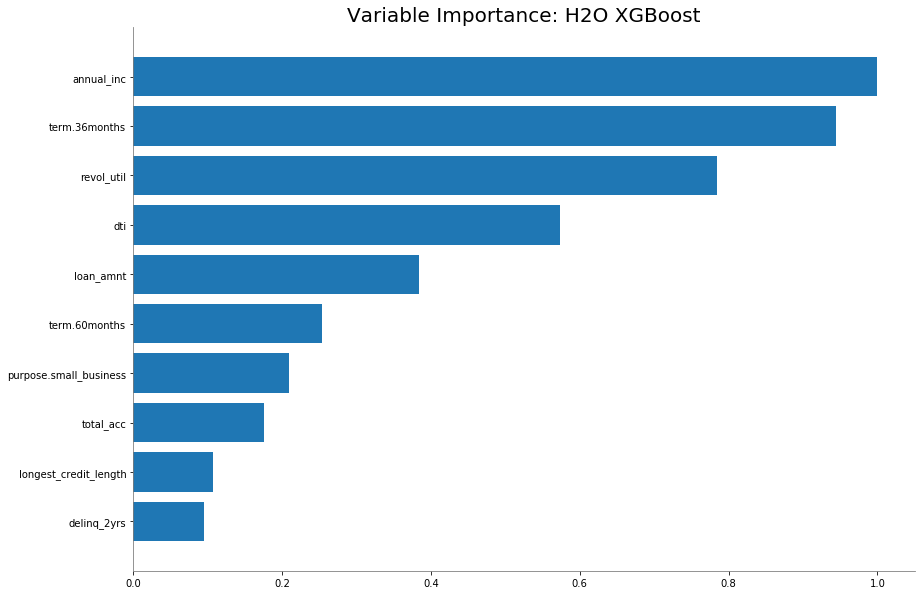

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

select_model.varimp_plot()

Note that `addr_state`, a high-cardinality categorical variable, is the most important variable. We will next try some feature engineering to see whether we can improve this model's overall performance.

# Step 4 (of 7). Feature Engineering to Improve Model Performance

The goal of this section is to improve upon these predictors through a number of feature engineering steps. In particular, we will perform four feature engineering tasks on select variables:

**Creating Target Encoding** 
   - Loan Purpose
   - State of Residence

**Separating Typical from Extreme**
   - Loan Amount
   - Annual Income
   - Debt to Income Ratio
   - Number of Delinquencies in the Past 2 Years
   - Revolving Credit Line Utilized
   - Number of Credit Lines
   - Longest Credit Length

**Creating Indicator Functions**
   - Term
   - Income Verification Status
   - Employment Length (Missing Value)

**Combining Categories** 
   - Home Ownership

## 1. Creating Target Encoding

### Cross Validation with Target Encoding

Some of the engineered features will use [cross-validated mean target encoding](https://github.com/h2oai/h2o-tutorials/blob/master/best-practices/categorical-predictors/target_encoding.md) of categorical predictors since one-hot encodings can lead to overfitting of infrequent categories.

To achieve this goal, we will first create soft partitions using H2OFrame's [`kfold_column`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html?highlight=kfold_column#h2o.frame.H2OFrame.kfold_column) function, then calculate summary statistics using H2O's [`group_by`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html#groupby) function, and finally join these engineered features using H2OFrame's [`merge`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html?highlight=merge#h2o.frame.H2OFrame.merge).

In [16]:
y = "bad_loan"
x_orig = train.col_names
x_orig.remove(y)
x_orig.remove("int_rate")

x_trans = x_orig.copy()

In [17]:
cv_nfolds = 5
cv_seed = 1234
train["cv_fold"] = train.kfold_column(n_folds = cv_nfolds, seed = cv_seed)

train["cv_fold"].table()

cv_fold,Count
0,24674
1,24621
2,24740
3,24478
4,24549


In [18]:
import numpy as np
import pandas as pd

In [19]:
def logit(p):
    return np.log(p) - np.log(1 - p)

In [20]:
def mean_target(data, x, y = "bad_loan"):
    grouped_data = data[[x, y]].group_by([x])
    stats = grouped_data.count(na = "ignore").mean(na = "ignore")
    return stats.get_frame().as_data_frame()

In [21]:
def mean_target_encoding(data, x, y = "bad_loan", fold_column = "cv_fold", prior_mean = 0.183, prior_count = 1):
    """
    Creates target encoding for binary target
    data (H2OFrame) : data set
    x (string) : categorical predictor column name
    y (string) : binary target column name
    fold_column (string) : cross-validation fold column name
    prior_mean (float) : proportion of 1s in the target column
    prior_count (positive number) : weight to give to prior_mean
    """ 
    grouped_data = data[[x, fold_column, y]].group_by([x, fold_column])
    grouped_data.sum(na = "ignore").count(na = "ignore")
    df = grouped_data.get_frame().as_data_frame()
    df_list = []
    nfold = int(data[fold_column].max()) + 1
    for j in range(0, nfold):
        te_x = "te_{}".format(x)
        sum_y = "sum_{}".format(y)
        oof = df.loc[df[fold_column] != j, [x, sum_y, "nrow"]]
        stats = oof.groupby([x]).sum()
        stats[x] = stats.index
        stats[fold_column] = j
        p = (stats[sum_y] + (prior_count * prior_mean)) / (stats["nrow"] + prior_count)
        stats[te_x] = logit(p)
        df_list.append(stats[[x, fold_column, te_x]])
    return h2o.H2OFrame(pd.concat(df_list))

### 1.1. Creating Target Encoding for Loan Purpose

In [22]:
tbl = train["purpose"].table().as_data_frame()
tbl["Percent"] = np.round((100 * tbl["Count"]/train.nrows), 2)
tbl = tbl.sort_values(by = "Count", ascending = 0)
tbl = tbl.reset_index(drop = True)
print(tbl)

               purpose  Count  Percent
0   debt_consolidation  69976    56.86
1          credit_card  23082    18.76
2                other   7916     6.43
3     home_improvement   7346     5.97
4       major_purchase   3535     2.87
5       small_business   2912     2.37
6                  car   2126     1.73
7              medical   1540     1.25
8              wedding   1320     1.07
9               moving   1091     0.89
10               house    937     0.76
11            vacation    834     0.68
12         educational    303     0.25
13    renewable_energy    144     0.12


Given that there is a high concentration of loans for debt consolidation (56.87%), a sizable number for credit card (18.78%), and the remaining 24.35% loans are spread amongst 12 other purposes, we will use mean target encoding to avoid overfitting the later group.

In [23]:
df = mean_target(train, "purpose")

df = df.sort_values(by = "mean_bad_loan", ascending = 0)
df = df.reset_index(drop = True)
df

,purpose,nrow,mean_bad_loan
0,small_business,2912,0.305975
1,other,7916,0.218671
2,educational,303,0.211221
3,moving,1091,0.206233
4,renewable_energy,144,0.201389
5,medical,1540,0.194156
6,debt_consolidation,69976,0.189465
7,house,937,0.177161
8,vacation,834,0.171463
9,credit_card,23082,0.155966


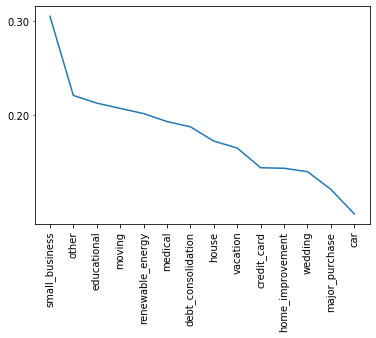

In [24]:
plt.xticks(rotation = 90)
plt.yscale("logit")
plt.plot(df["purpose"], df["mean_bad_loan"])

In [25]:
te_purpose = mean_target_encoding(train, "purpose")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [26]:
train = train.merge(te_purpose, all_x = True)

Replace `purpose` with target encoded `te_purpose`

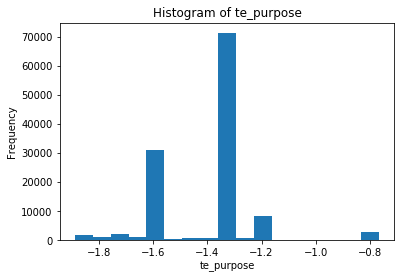

In [27]:
x_trans.remove("purpose")
x_trans.append("te_purpose")

train["te_purpose"].hist()

### 1.2. Target Encoding for State of Residence

We will also use a mean target encoding for *state of residence* for a reason similar to that for *purpose*.

In [28]:
tbl = train["addr_state"].table().as_data_frame()
tbl["Percent"] = np.round((100 * tbl["Count"]/train.nrows), 2)
tbl = tbl.sort_values(by = "Count", ascending = 0)
tbl = tbl.reset_index(drop = True)
print(tbl[0:10])

  addr_state  Count  Percent
0         CA  21493    17.47
1         NY  10699     8.69
2         TX   9188     7.47
3         FL   8554     6.95
4         NJ   4755     3.86
5         IL   4564     3.71
6         PA   4090     3.32
7         VA   3957     3.22
8         GA   3937     3.20
9         OH   3666     2.98


In [29]:
df = mean_target(train, "addr_state")

df = df.sort_values(by = "mean_bad_loan", ascending = 0)
df = df.reset_index(drop = True)
df

,addr_state,nrow,mean_bad_loan
0,NE,8,0.625000
1,IA,7,0.285714
2,MS,124,0.233871
3,NV,1764,0.231859
4,TN,977,0.220061
5,AL,1485,0.217508
6,IN,1086,0.214549
7,OK,993,0.214502
8,FL,8554,0.210077
9,NJ,4755,0.204627


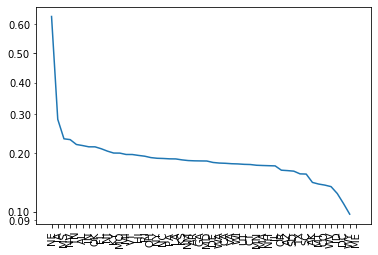

In [30]:
plt.yscale("logit")
plt.xticks(rotation = 90)
plt.plot(df["addr_state"], df["mean_bad_loan"])

In [31]:
te_addr_state = mean_target_encoding(train, "addr_state", prior_count = 30)

Parse progress: |█████████████████████████████████████████████████████████| 100%


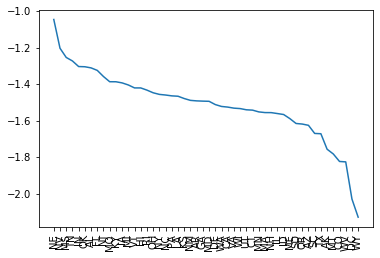

In [32]:
grouped_data = te_addr_state[["addr_state", "te_addr_state"]].group_by(["addr_state"])
df = grouped_data.count(na = "ignore").mean(na = "ignore").get_frame().as_data_frame()

df = df.sort_values(by = "mean_te_addr_state", ascending = 0)
df = df.reset_index(drop = True)

plt.xticks(rotation = 90)
plt.plot(df["addr_state"], df["mean_te_addr_state"])

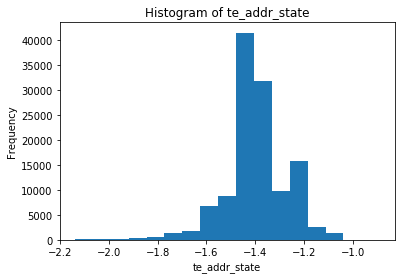

In [33]:
train = train.merge(te_addr_state, all_x = True)

x_trans.remove("addr_state")
x_trans.append("te_addr_state")

train["te_addr_state"].hist()

## 2. Separating Typical from Extreme

### 2.1. Separating Typical from Extreme Loan Amount

After binning `loan_amt` using H2OFrame's [`cut`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html?highlight=cut#h2o.frame.H2OFrame.cut) function and looking at the fraction of bad loans on a logit scale, we see that the chance of a bad loan roughly increases linearly in loan amount from \\$5,000 to \\$30,000 and is relatively flat below \\$5,000 and above \\$30,000. To reflect this finding in the modeling, we will replace the original `loan_amnt` measure with two derived measures:

\begin{eqnarray}
\text{loan_amnt_core} & = & \max(5000, \min(\text{loan_amnt}, 30000)) \\
\text{loan_amnt_diff} & = & \text{loan_amnt} - \text{loan_amnt_core}
\end{eqnarray}

In [34]:
train["loan_amnt"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,loan_amntQuantiles
0,500
0.05,3000
0.25,7000
0.5,11400
0.75,18000
0.95,30000
1,35000


In [35]:
breaks = np.linspace(0, 35000, 8).tolist()
train["loan_amnt_cat"] = train["loan_amnt"].cut(breaks = breaks)

df = mean_target(train, "loan_amnt_cat")
df

,loan_amnt_cat,nrow,mean_bad_loan
0,"(0.0,5000.0]",19317,0.163845
1,"(5000.0,10000.0]",37730,0.164431
2,"(10000.0,15000.0]",26782,0.173288
3,"(15000.0,20000.0]",18485,0.209413
4,"(20000.0,25000.0]",10829,0.211931
5,"(25000.0,30000.0]",5223,0.241432
6,"(30000.0,35000.0]",4696,0.228705


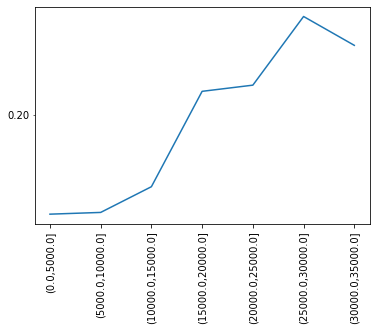

In [36]:
plt.xticks(rotation = 90)
plt.yscale("logit")
plt.plot(df["loan_amnt_cat"], df["mean_bad_loan"])

In [37]:
x_trans.remove("loan_amnt")
x_trans.append("loan_amnt_core")
x_trans.append("loan_amnt_delta")

train["loan_amnt_core"] = h2o.H2OFrame.ifelse(train["loan_amnt"] <= 5000, 5000, train["loan_amnt"])
train["loan_amnt_core"] = h2o.H2OFrame.ifelse(train["loan_amnt_core"] <= 30000, train["loan_amnt_core"], 30000)

train["loan_amnt_delta"] = train["loan_amnt"] - train["loan_amnt_core"]

### 2.2. Separating Typical from Extreme Annual Income

Looking at the occurrence of bad loans on a logit scale reveal that the chance of a bad loan roughly decreases linearly in annual income from \\$10,000 to \\$105,000 and is relatively flat above \\$105,000. To reflect this finding in the modeling, we will replace the original `annual_inc` measure with two derived measures:

\begin{eqnarray}
\text{annual_inc_core} & = & \max(10000, \min(\text{annual_inc}, 105000)) \\
\text{annual_inc_diff} & = & \text{annual_inc} - \text{annual_inc_core}
\end{eqnarray}

In [38]:
train["annual_inc"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,annual_incQuantiles
0,3000
0.05,27000
0.25,45000
0.5,61000
0.75,85000
0.95,146000
1,6.1e+06


In [39]:
breaks = np.linspace(0, 150000, 31).tolist()
train["annual_inc_cat"] = train["annual_inc"].cut(breaks = breaks)

df = mean_target(train, "annual_inc_cat")
df.drop(df.index[:1], inplace=True) # remove NaN
df

,annual_inc_cat,nrow,mean_bad_loan
1,"(0.0,5000.0]",17,0.294118
2,"(5000.0,10000.0]",145,0.213793
3,"(10000.0,15000.0]",668,0.282934
4,"(15000.0,20000.0]",1364,0.249267
5,"(20000.0,25000.0]",2929,0.235575
6,"(25000.0,30000.0]",4942,0.238770
7,"(30000.0,35000.0]",6058,0.230934
8,"(35000.0,40000.0]",8778,0.232969
9,"(40000.0,45000.0]",8876,0.212483
10,"(45000.0,50000.0]",9555,0.206593


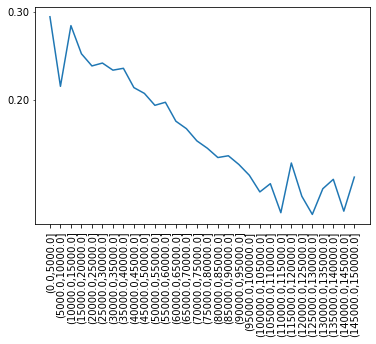

In [40]:
plt.yscale("logit")
plt.xticks(rotation = 90)
plt.plot(df["annual_inc_cat"], df["mean_bad_loan"])

In [41]:
x_trans.remove("annual_inc")
x_trans.append("annual_inc_core")
x_trans.append("annual_inc_delta")

train["annual_inc_core"] = h2o.H2OFrame.ifelse(train["annual_inc"] <= 10000, 10000, train["annual_inc"])
train["annual_inc_core"] = h2o.H2OFrame.ifelse(train["annual_inc_core"] <= 105000,
                                               train["annual_inc_core"], 105000)

train["annual_inc_delta"] = train["annual_inc"] - train["annual_inc_core"]

### 2.3. Separating Typical from Extreme Debt to Income Ratio

Looking at the occurance of bad loans on a logit scale reveal that the chance of a bad loan roughly increases linearly in debt-to-income from 5% to 30% and is highly volatile outside of that range due to small numbers of observations. To reflect this finding in the modeling, we will replace the original `dti` measure with two derived measures:

\begin{eqnarray}
\text{dti_core} & = & \max(5, \min(\text{dti}, 30)) \\
\text{dti_diff} & = & \text{dti} - \text{dti_core}
\end{eqnarray}

In [42]:
train["dti"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,dtiQuantiles
0,0
0.05,3.76
0.25,10.2
0.5,15.6
0.75,21.25
0.95,29.01
1,39.93


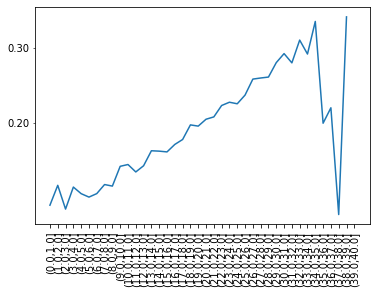

In [43]:
breaks = np.linspace(0, 40, 41).tolist()
train["dti_cat"] = train["dti"].cut(breaks = breaks)

df = mean_target(train, "dti_cat")
df.drop(df.index[:1], inplace=True) # remove NaN

plt.yscale("logit")
plt.xticks(rotation = 90)
plt.plot(df["dti_cat"], df["mean_bad_loan"])

In [44]:
df

,dti_cat,nrow,mean_bad_loan
1,"(0.0,1.0]",1136,0.122359
2,"(1.0,2.0]",1438,0.138387
3,"(2.0,3.0]",1767,0.119411
4,"(3.0,4.0]",2191,0.136924
5,"(4.0,5.0]",2693,0.131452
6,"(5.0,6.0]",3186,0.128688
7,"(6.0,7.0]",3612,0.131506
8,"(7.0,8.0]",4142,0.139063
9,"(8.0,9.0]",4603,0.137736
10,"(9.0,10.0]",4841,0.155340


In [45]:
x_trans.remove("dti")
x_trans.append("dti_core")
x_trans.append("dti_delta")

train["dti_core"] = h2o.H2OFrame.ifelse(train["dti"] <= 5, 5, train["dti"])
train["dti_core"] = h2o.H2OFrame.ifelse(train["dti_core"] <= 30, train["dti_core"], 30)

train["dti_delta"] = train["dti"] - train["dti_core"]

### 2.4. Separating Typical from Extreme Number of Delinquencies in the Past 2 Years

The chance of a bad loan seems to max out at 3 delinquent payments in the past two years. To reflect this finding in the modeling, we will replace the original `delinq_2yrs` measure with two derived measures:

\begin{eqnarray}
\text{delinq_2yrs_core} & = & \min(\text{delinq_2yrs}, 3) \\
\text{delinq_2yrs_diff} & = & \text{delinq_2yrs} - \text{delinq_2yrs_core}
\end{eqnarray}

In [46]:
train["delinq_2yrs"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,delinq_2yrsQuantiles
0,0
0.05,0
0.25,0
0.5,0
0.75,0
0.95,1
1,18


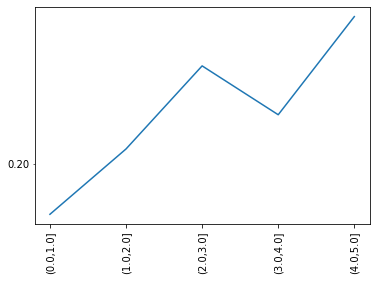

In [47]:
breaks = np.linspace(0, 5, 6).tolist()
train["delinq_2yrs_cat"] = train["delinq_2yrs"].cut(breaks = breaks)

df = mean_target(train, "delinq_2yrs_cat")
df.drop(df.index[:1], inplace=True) # remove NaN

plt.yscale("logit")
plt.xticks(rotation = 90)
plt.plot(df["delinq_2yrs_cat"], df["mean_bad_loan"])

In [48]:
df

,delinq_2yrs_cat,nrow,mean_bad_loan
1,"(0.0,1.0]",12879,0.189766
2,"(1.0,2.0]",3467,0.203057
3,"(2.0,3.0]",1127,0.220941
4,"(3.0,4.0]",447,0.210291
5,"(4.0,5.0]",237,0.232068


In [49]:
x_trans.remove("delinq_2yrs")
x_trans.append("delinq_2yrs_core")
x_trans.append("delinq_2yrs_delta")

train["delinq_2yrs_core"] = h2o.H2OFrame.ifelse(train["delinq_2yrs"] <= 3, train["delinq_2yrs"], 3)
train["delinq_2yrs_delta"] = train["delinq_2yrs"] - train["delinq_2yrs_core"]

### 2.5. Separating Typical from Extreme Revolving Credit Line Utilized

The relationship between credit line utilized is somewhat interesting. There appears to be a higher rate for a bad loan when 0% of the credit lines are utilized, then it drops down slightly and roughly increases linearly in credit line utilized up to 100%. To reflect this finding in the modeling, we will replace the original `revol_util` measure with three derived measures:

\begin{eqnarray}
\text{revol_util_0} & = & I(\text{revol_util} == 0) \\
\text{revol_util_core} & = & \max(5, \min(\text{revol_util}, 30)) \\
\text{revol_util_diff} & = & \text{revol_util} - \text{revol_util_core}
\end{eqnarray}

In [50]:
train["revol_util"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,revol_utilQuantiles
0,0
0.05,8.6
0.25,35.5
0.5,55.9
0.75,74.3
0.95,92.4
1,150.7


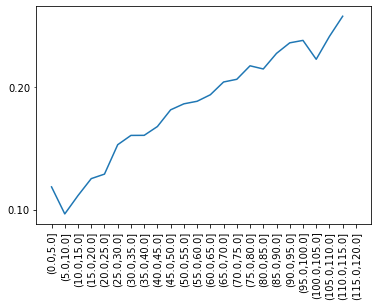

In [51]:
breaks = np.linspace(0, 120, 25).tolist()
train["revol_util_cat"] = train["revol_util"].cut(breaks = breaks)

df = mean_target(train, "revol_util_cat")
df.drop(df.index[:1], inplace=True) # remove NaN

plt.yscale("logit")
plt.xticks(rotation = 90)
plt.plot(df["revol_util_cat"], df["mean_bad_loan"])

In [52]:
df

,revol_util_cat,nrow,mean_bad_loan
1,"(0.0,5.0]",2833,0.114366
2,"(5.0,10.0]",3089,0.097443
3,"(10.0,15.0]",3294,0.108682
4,"(15.0,20.0]",3874,0.120031
5,"(20.0,25.0]",4577,0.123225
6,"(25.0,30.0]",5272,0.145865
7,"(30.0,35.0]",6005,0.153705
8,"(35.0,40.0]",6679,0.153766
9,"(40.0,45.0]",7182,0.161515
10,"(45.0,50.0]",7895,0.177074


In [53]:
x_trans.remove("revol_util")
x_trans.append("revol_util_0")
x_trans.append("revol_util_core")
x_trans.append("revol_util_delta")

train["revol_util_0"] = train["revol_util"] == 0
train["revol_util_core"] = h2o.H2OFrame.ifelse(train["revol_util"] <= 100, train["revol_util"], 100)
train["revol_util_delta"] = train["revol_util"] - train["revol_util_core"]

### 2.6. Separating Typical from Extreme Number of Credit Lines

Looking at the occurance of bad loans on a logit scale reveal that the chance of a bad loan roughly decreases linearly in number of lines of credit up to about 50. To reflect this finding in the modeling, we will replace the original `total_acc` measure with two derived measures:

\begin{eqnarray}
\text{total_acc_core} & = & \min(\text{total_acc}, 50) \\
\text{total_acc_diff} & = & \text{total_acc} - \text{total_acc_core}
\end{eqnarray}

In [54]:
train["total_acc"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,total_accQuantiles
0,1
0.05,8
0.25,16
0.5,23
0.75,31
0.95,46
1,102


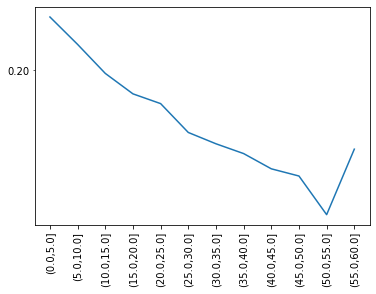

In [55]:
breaks = np.linspace(0, 60, 13).tolist()
train["total_acc_cat"] = train["total_acc"].cut(breaks = breaks)

df = mean_target(train, "total_acc_cat")
df.drop(df.index[:1], inplace=True) # remove NaN

plt.yscale("logit")
plt.xticks(rotation = 90)
plt.plot(df["total_acc_cat"], df["mean_bad_loan"])

In [56]:
df

,total_acc_cat,nrow,mean_bad_loan
1,"(0.0,5.0]",1753,0.225328
2,"(5.0,10.0]",9578,0.212048
3,"(10.0,15.0]",17664,0.198653
4,"(15.0,20.0]",21658,0.189584
5,"(20.0,25.0]",21346,0.185374
6,"(25.0,30.0]",17509,0.173339
7,"(30.0,35.0]",12921,0.168795
8,"(35.0,40.0]",8476,0.164936
9,"(40.0,45.0]",5312,0.159074
10,"(45.0,50.0]",3153,0.156359


In [57]:
(train["total_acc"] == None).table()

C1,Count
0,123039
1,23


In [58]:
x_trans.remove("total_acc")
x_trans.append("total_acc_core")
x_trans.append("total_acc_delta")

train["total_acc_core"] = h2o.H2OFrame.ifelse(train["total_acc"] <= 50, train["total_acc"], 50)
train["total_acc_delta"] = train["total_acc"] - train["total_acc_core"]

### 2.7. Separating Typical from Extreme Longest Credit Length

Looking at the occurance of bad loans on a logit scale reveal that the chance of a bad loan roughly decreases linearly in longest credit length from 3 to 20 years and is highly volatile outside of that range due to small numbers of observations. To reflect this finding in the modeling, we will replace the original `longest_credit_length` measure with two derived measures:

\begin{eqnarray}
\text{longest_credit_length_core} & = & \max(3, \min(\text{longest_credit_length}, 20)) \\
\text{longest_credit_length_diff} & = & \text{longest_credit_length} - \text{longest_credit_length_core}
\end{eqnarray}

In [59]:
train["longest_credit_length"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,longest_credit_lengthQuantiles
0,0
0.05,6
0.25,10
0.5,14
0.75,18
0.95,28
1,65


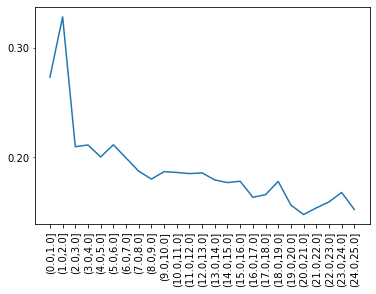

In [60]:
breaks = np.linspace(0, 25, 26).tolist()
train["longest_credit_length_cat"] = train["longest_credit_length"].cut(breaks = breaks)

df = mean_target(train, "longest_credit_length_cat")
df.drop(df.index[:1], inplace=True) # remove NaN

plt.yscale("logit")
plt.xticks(rotation = 90)
plt.plot(df["longest_credit_length_cat"], df["mean_bad_loan"])

In [61]:
df

,longest_credit_length_cat,nrow,mean_bad_loan
1,"(0.0,1.0]",48,0.270833
2,"(1.0,2.0]",72,0.333333
3,"(2.0,3.0]",700,0.208571
4,"(3.0,4.0]",1881,0.209995
5,"(4.0,5.0]",2999,0.200400
6,"(5.0,6.0]",4016,0.210159
7,"(6.0,7.0]",4760,0.199580
8,"(7.0,8.0]",5302,0.189363
9,"(8.0,9.0]",5729,0.183453
10,"(9.0,10.0]",7349,0.189005


In [62]:
x_trans.remove("longest_credit_length")
x_trans.append("longest_credit_length_core")
x_trans.append("longest_credit_length_delta")

train["longest_credit_length_core"] = h2o.H2OFrame.ifelse(train["longest_credit_length"] <= 3,
                                                          3, train["longest_credit_length"])
train["longest_credit_length_core"] = h2o.H2OFrame.ifelse(train["longest_credit_length_core"] <= 20,
                                                          train["longest_credit_length_core"], 20)
train["longest_credit_length_delta"] = train["longest_credit_length"] - train["longest_credit_length_core"]

## 3. Create Indicator Functions

### 3.1. Converting Term to a 0/1 Indicator

Given that term of the loans are either 3 or 5 years, we will create a simplifed `term_36month` binary indicator that is 1 when the terms of the loan is for 5 years and 0 for loans with a term of 3 years.

In [63]:
train["term"].table()

term,Count
36 months,97490
60 months,25572


In [64]:
x_trans.remove("term")
x_trans.append("term_60months")

train["term_60months"] = train["term"] == "60 months"

train["term_60months"].table()

term_60months,Count
0,97490
1,25572


### 3.2. Converting Income Verification Status to a 0/1 Indicator

Given that incomes are either verified or not verified, we will create a simplifed `verified` binary indicator that is 1 when income has been verified.

In [65]:
train["verification_status"].table()

verification_status,Count
not verified,44247
verified,78815


In [66]:
x_trans.remove("verification_status")
x_trans.append("verified")

train["verified"] = train["verification_status"] == "verified"
train["verified"].table()

verified,Count
0,44247
1,78815


### 3.3. Creating Missing Value Indicator for Employment Length

The most interesting characteristic about employment length is whether or not it is missing. The divide between those with missing values for employment length to those who have a recorded employment length is 26.3% bad loans to 18.0% bad loans respectively. Interestingly, there doesn't appear to be any differences in bad loans across employment lengths.

In [67]:
train["emp_length"].summary()

,emp_length
type,int
mins,0.0
mean,5.6807001583611285
maxs,10.0
sigma,3.610320673601876
zeros,10727
missing,4346
0,nan
1,7.0
2,2.0


In [68]:
x_trans.append("emp_length_missing")
train["emp_length_missing"] = train["emp_length"] == None

mean_target_encoding(train, "emp_length_missing")

Parse progress: |█████████████████████████████████████████████████████████| 100%


emp_length_missing,cv_fold,te_emp_length_missing
0,0,-1.52085
1,0,-1.0216
0,1,-1.51402
1,1,-1.06329
0,2,-1.51493
1,2,-1.03287
0,3,-1.51542
1,3,-0.986137
0,4,-1.51821
1,4,-1.01942


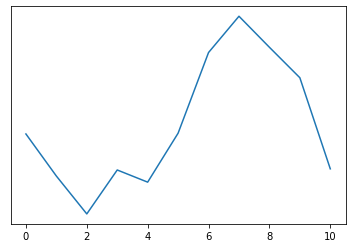

In [69]:
df = mean_target(train, "emp_length")
df.drop(df.index[:1], inplace=True) # remove NaN

plt.yscale("logit")
plt.plot(df["emp_length"], df["mean_bad_loan"])

In [70]:
df

,emp_length,nrow,mean_bad_loan
1,0.0,10727,0.180852
2,1.0,8506,0.176699
3,2.0,11877,0.173023
4,3.0,10243,0.177292
5,4.0,8285,0.176101
6,5.0,9313,0.180930
7,6.0,7472,0.189106
8,7.0,6766,0.192876
9,8.0,5584,0.189649
10,9.0,4600,0.186522


## 4. Combining Categories
### 4.1.  Combining Categories in Home Ownership

Although there are 6 recorded categories within home ownership, only three had over 200 observations: OWN, MORTGAGE, and RENT. The remaining three are so infrequent we will combine them {ANY, NONE, OTHER} with RENT to form an enlarged OTHER category. This new `home_ownership_3cat` variable will have values in {MORTGAGE, OTHER, OWN}.

In [71]:
mean_target(train, "home_ownership")

,home_ownership,nrow,mean_bad_loan
0,MORTGAGE,59901,0.162835
1,NONE,27,0.259259
2,OTHER,116,0.215517
3,OWN,10165,0.189670
4,RENT,52853,0.204284


In [72]:
lvls = ["OTHER", "MORTGAGE", "OTHER", "OTHER", "OWN", "OTHER"]
train["home_ownership_3cat"] = train["home_ownership"].set_levels(lvls).ascharacter().asfactor()
train[["home_ownership", "home_ownership_3cat"]].table()

home_ownership,home_ownership_3cat,Counts
MORTGAGE,MORTGAGE,59901
NONE,OTHER,27
OTHER,OTHER,116
OWN,OWN,10165
RENT,OTHER,52853


In [73]:
mean_target(train, "home_ownership_3cat")

,home_ownership_3cat,nrow,mean_bad_loan
0,MORTGAGE,59901,0.162835
1,OTHER,52996,0.204336
2,OWN,10165,0.189670


In [74]:
x_trans.remove("home_ownership")
x_trans.append("home_ownership_3cat")

# Step 5 (of 7). Train Models using Transformed Data

The complete variable set, including transformed variables, are

In [75]:
x_trans

['emp_length',
 'te_purpose',
 'te_addr_state',
 'loan_amnt_core',
 'loan_amnt_delta',
 'annual_inc_core',
 'annual_inc_delta',
 'dti_core',
 'dti_delta',
 'delinq_2yrs_core',
 'delinq_2yrs_delta',
 'revol_util_0',
 'revol_util_core',
 'revol_util_delta',
 'total_acc_core',
 'total_acc_delta',
 'longest_credit_length_core',
 'longest_credit_length_delta',
 'term_60months',
 'verified',
 'emp_length_missing',
 'home_ownership_3cat']

We now fit a new set of models using AutoML

In [76]:
aml_trans = H2OAutoML(max_models = 6, exclude_algos = ['DeepLearning'])
aml_trans.train(x = x_trans, y = y, training_frame = train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [77]:
print(aml_trans.leaderboard)

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20190902_055735,0.683164,0.445252,0.366387,0.37409,0.139943
StackedEnsemble_BestOfFamily_AutoML_20190902_055735,0.682839,0.445379,0.366368,0.374148,0.139987
XGBoost_3_AutoML_20190902_055735,0.682459,0.44388,0.367108,0.373588,0.139568
GBM_1_AutoML_20190902_055735,0.681359,0.444426,0.368432,0.373901,0.139802
XGBoost_1_AutoML_20190902_055735,0.678271,0.445368,0.372839,0.374381,0.140161
GLM_grid_1_AutoML_20190902_055735_model_1,0.676896,0.445621,0.37133,0.374356,0.140142
XGBoost_2_AutoML_20190902_055735,0.672646,0.44788,0.375054,0.375428,0.140946
DRF_1_AutoML_20190902_055735,0.661107,0.452883,0.383264,0.377558,0.14255


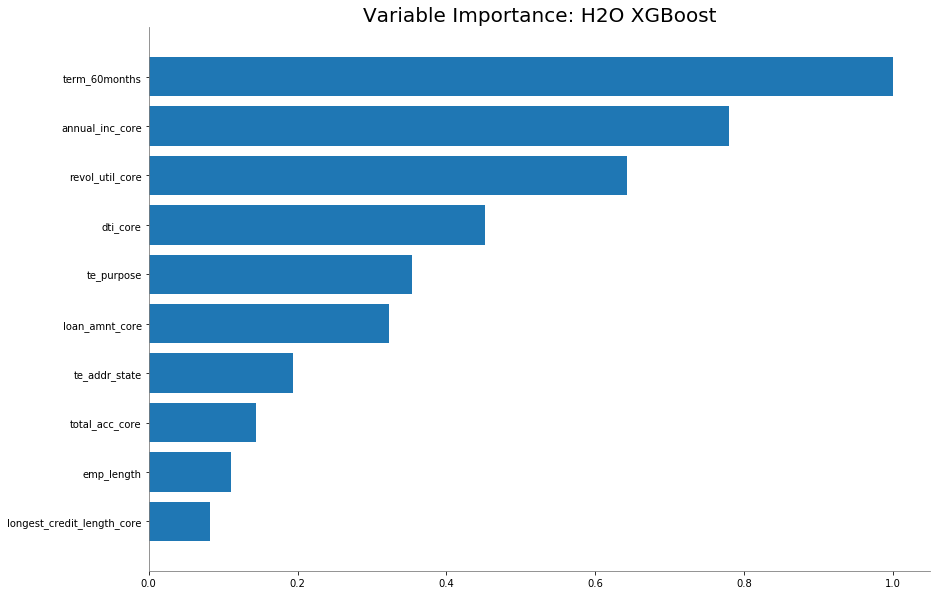

In [78]:
best_model_trans = h2o.get_model(aml_trans.leaderboard[2,'model_id'])
best_model_trans.varimp_plot()

In [79]:
print("AUC     (transformed): train = {:.4f}, xval = {:.4f}" \
      .format(best_model_trans.auc(train = True),
              best_model_trans.auc(xval = True)))
print("Logloss (transformed): train = {:.4f}, xval = {:.4f}" \
      .format(best_model_trans.logloss(train = True),
              best_model_trans.logloss(xval = True)))

AUC     (transformed): train = 0.7039, xval = 0.6825
Logloss (transformed): train = 0.4360, xval = 0.4439


Note that the cross-validated model performance is now much closer to that of the training model. 


# Step 6 (of 7). Assignment: Transform Test Data (Optional)

In order to use the `model_performance` command to evaluate the model on the holdout training data set, you will need to transform the training data using the same feature engineering transformations created above. In other words, transform the data from


In [80]:
y = "bad_loan"
x_test = test.col_names
x_test.remove(y)
x_test.remove("int_rate")
x_test

['loan_amnt',
 'term',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'purpose',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'revol_util',
 'total_acc',
 'longest_credit_length',
 'verification_status']

to the variables below

In [81]:
x_trans

['emp_length',
 'te_purpose',
 'te_addr_state',
 'loan_amnt_core',
 'loan_amnt_delta',
 'annual_inc_core',
 'annual_inc_delta',
 'dti_core',
 'dti_delta',
 'delinq_2yrs_core',
 'delinq_2yrs_delta',
 'revol_util_0',
 'revol_util_core',
 'revol_util_delta',
 'total_acc_core',
 'total_acc_delta',
 'longest_credit_length_core',
 'longest_credit_length_delta',
 'term_60months',
 'verified',
 'emp_length_missing',
 'home_ownership_3cat']

# Step 7 (of 7). Shutdown H2O Cluster

In [82]:
h2o.cluster().shutdown()

H2O session _sid_ad21 closed.
